In [1]:
# install the required libraries because the code was run on NYU HPC and these were not already installed

!pip install opencv-python
!pip install tqdm
!pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/pc2442/.local/lib/python3.8/site-packages (1.3.2)
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [2]:
# import all necessary libraries to be used

import numpy as np
import cv2
import os
import warnings
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch

from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import BallTree

In [3]:
# if a GPU is available then use CUDA otherwise use the CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# define all the paths and how many final matches per query you want
database_path = '/scratch/pc2442/RP_HW/database/'
query_path = '/scratch/pc2442/RP_HW/query/'
num_of_imgs = 1

In [4]:
# define helper functions

def get_descriptor_super_point(img, model):
    # put the model in inference mode
    model.eval()
    # read in an image and transform it into a tensor to be fed into the model
    _, model_input = read_image(img, device)
    # use the model to get a prediction
    prediction = model({'image': model_input})
    # use the prediction to get the descriptor of the image
    descriptor = prediction['descriptors'][0]
    # process the descriptor to get into a numpy array of float64 and return it
    descriptor = torch.transpose(descriptor, 0, 1)
    descriptor = descriptor.cpu().detach().numpy()
    descriptor = descriptor.astype(np.float64)
    return descriptor

def convert_to_tensor(frame, device):
    # convert the image to tensor and send it to the device (i.e. the GPU)
    return torch.from_numpy(frame/255.).float()[None, None].to(device)

def read_image(path, device):
    # read the image from the path
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)

    if image is None:
        return None, None, None
    # convert it to a tensor
    model_input = convert_to_tensor(image, device)
    # return both the image as a numpy array and as a tensor
    return image, model_input

In [5]:
# this is super point from the github source.
# this work was used directly from their repo
# i copied it here because I had trouble using it as a library module

from pathlib import Path
import torch
from torch import nn

def simple_nms(scores, nms_radius: int):
    """ Fast Non-maximum suppression to remove nearby points """
    assert(nms_radius >= 0)

    def max_pool(x):
        return torch.nn.functional.max_pool2d(
            x, kernel_size=nms_radius*2+1, stride=1, padding=nms_radius)

    zeros = torch.zeros_like(scores)
    max_mask = scores == max_pool(scores)
    for _ in range(2):
        supp_mask = max_pool(max_mask.float()) > 0
        supp_scores = torch.where(supp_mask, zeros, scores)
        new_max_mask = supp_scores == max_pool(supp_scores)
        max_mask = max_mask | (new_max_mask & (~supp_mask))
    return torch.where(max_mask, scores, zeros)


def remove_borders(keypoints, scores, border: int, height: int, width: int):
    """ Removes keypoints too close to the border """
    mask_h = (keypoints[:, 0] >= border) & (keypoints[:, 0] < (height - border))
    mask_w = (keypoints[:, 1] >= border) & (keypoints[:, 1] < (width - border))
    mask = mask_h & mask_w
    return keypoints[mask], scores[mask]


def top_k_keypoints(keypoints, scores, k: int):
    if k >= len(keypoints):
        return keypoints, scores
    scores, indices = torch.topk(scores, k, dim=0)
    return keypoints[indices], scores


def sample_descriptors(keypoints, descriptors, s: int = 8):
    """ Interpolate descriptors at keypoint locations """
    b, c, h, w = descriptors.shape
    keypoints = keypoints - s / 2 + 0.5
    keypoints /= torch.tensor([(w*s - s/2 - 0.5), (h*s - s/2 - 0.5)],
                              ).to(keypoints)[None]
    keypoints = keypoints*2 - 1  # normalize to (-1, 1)
    args = {'align_corners': True} if int(torch.__version__[2]) > 2 else {}
    descriptors = torch.nn.functional.grid_sample(
        descriptors, keypoints.view(b, 1, -1, 2), mode='bilinear', **args)
    descriptors = torch.nn.functional.normalize(
        descriptors.reshape(b, c, -1), p=2, dim=1)
    return descriptors


class SuperPoint(nn.Module):
    """SuperPoint Convolutional Detector and Descriptor

    SuperPoint: Self-Supervised Interest Point Detection and
    Description. Daniel DeTone, Tomasz Malisiewicz, and Andrew
    Rabinovich. In CVPRW, 2019. https://arxiv.org/abs/1712.07629

    """
    default_config = {
        'descriptor_dim': 256,
        'nms_radius': 4,
        'keypoint_threshold': 0.005,
        'max_keypoints': -1,
        'remove_borders': 4,
    }

    def __init__(self, config):
        super().__init__()
        self.config = {**self.default_config, **config}

        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5 = 64, 64, 128, 128, 256

        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)

        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)

        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(
            c5, self.config['descriptor_dim'],
            kernel_size=1, stride=1, padding=0)

        path = '/scratch/pc2442/RP_HW/weights/superpoint_v1.pth'
        self.load_state_dict(torch.load(str(path)))

        mk = self.config['max_keypoints']
        if mk == 0 or mk < -1:
            raise ValueError('\"max_keypoints\" must be positive or \"-1\"')

        print('Loaded SuperPoint model')

    def forward(self, data):
        """ Compute keypoints, scores, descriptors for image """
        # Shared Encoder
        x = self.relu(self.conv1a(data['image']))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))

        # Compute the dense keypoint scores
        cPa = self.relu(self.convPa(x))
        scores = self.convPb(cPa)
        scores = torch.nn.functional.softmax(scores, 1)[:, :-1]
        b, _, h, w = scores.shape
        scores = scores.permute(0, 2, 3, 1).reshape(b, h, w, 8, 8)
        scores = scores.permute(0, 1, 3, 2, 4).reshape(b, h*8, w*8)
        scores = simple_nms(scores, self.config['nms_radius'])

        # Extract keypoints
        keypoints = [
            torch.nonzero(s > self.config['keypoint_threshold'])
            for s in scores]
        scores = [s[tuple(k.t())] for s, k in zip(scores, keypoints)]

        # Discard keypoints near the image borders
        keypoints, scores = list(zip(*[
            remove_borders(k, s, self.config['remove_borders'], h*8, w*8)
            for k, s in zip(keypoints, scores)]))

        # Keep the k keypoints with highest score
        if self.config['max_keypoints'] >= 0:
            keypoints, scores = list(zip(*[
                top_k_keypoints(k, s, self.config['max_keypoints'])
                for k, s in zip(keypoints, scores)]))

        # Convert (h, w) to (x, y)
        keypoints = [torch.flip(k, [1]).float() for k in keypoints]

        # Compute the dense descriptors
        cDa = self.relu(self.convDa(x))
        descriptors = self.convDb(cDa)
        descriptors = torch.nn.functional.normalize(descriptors, p=2, dim=1)

        # Extract descriptors
        descriptors = [sample_descriptors(k[None], d[None], 8)[0]
                       for k, d in zip(keypoints, descriptors)]

        return {
            'keypoints': keypoints,
            'scores': scores,
            'descriptors': descriptors,
        }

In [6]:
# use the existing configuration and weights by using the file saved in the weights folder
# the super point model is pretrained and ready for inference so it is sent straight to the device
config = {}
model = SuperPoint(config).to(device)

Loaded SuperPoint model


In [7]:
# the following function extracts features from each image in the folder path and appends them into a list

def extract_features(folder_path):
    #initialize list to hold all the descriptors
    descriptors_list = list()

    for img_name in tqdm(os.listdir(folder_path)):
        # get descriptor using superpoint
        img_path = folder_path + img_name
        descriptor = get_descriptor_super_point(img_path, model)
        # append descriptor to list of descriptors
        descriptors_list.extend(descriptor)
    # convert descriptors list into a numpy array for further use
    descriptors_list = np.asarray(descriptors_list)

    return descriptors_list

In [8]:
# extract features from the whole database and store them
database_features = extract_features(database_path)

  0%|          | 0/14238 [00:00<?, ?it/s]/home/pc2442/.local/lib/python3.8/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|██████████| 14238/14238 [02:19<00:00, 102.20it/s]


In [9]:
# clustering all of the descriptors using mini batch k means for efficient memory utilization
# only 16 clusters and 1 iteration since the same images as the queries are in the database
cluster_dictionary = MiniBatchKMeans(n_clusters = 16, init='k-means++', n_init=1, verbose=1).fit(database_features)

Init 1/1 with method k-means++
Inertia for init 1/1: 4100.1477861902695
Minibatch step 1/1250329: mean batch inertia: 1.3181510496891844
Minibatch step 2/1250329: mean batch inertia: 0.8446147976418177, ewa inertia: 0.8446147976418177
Minibatch step 3/1250329: mean batch inertia: 0.8396696730550167, ewa inertia: 0.8446140066302041
Minibatch step 4/1250329: mean batch inertia: 0.8305675029277727, ewa inertia: 0.8446117597813405
Minibatch step 5/1250329: mean batch inertia: 0.8253781748395759, ewa inertia: 0.8446086832179917
Minibatch step 6/1250329: mean batch inertia: 0.8254967966510047, ewa inertia: 0.844605626121256
Minibatch step 7/1250329: mean batch inertia: 0.8269945116056573, ewa inertia: 0.8446028090848265
Minibatch step 8/1250329: mean batch inertia: 0.8227729692118345, ewa inertia: 0.8445993172300595
Minibatch step 9/1250329: mean batch inertia: 0.8262685692570155, ewa inertia: 0.8445963850825925
Minibatch step 10/1250329: mean batch inertia: 0.8186109605175091, ewa inertia: 

In [10]:
def VLAD(X, cluster_dictionary):
    # use the clusters to predict the label for each image by using their descriptor
    predictedLabels = cluster_dictionary.predict(X)
    # get the centroids of all the clusters
    centroids = cluster_dictionary.cluster_centers_
    # get the labels of all clusters
    labels = cluster_dictionary.labels_
    # get the number of clusters
    k = cluster_dictionary.n_clusters
    
    # initialize the array to hold the VLAD feature using the number of clusters
    # and the dimension of the descriptor
    m,d = X.shape
    VLAD_feature = np.zeros([k,d])

    # loop through all the clusters
    for i in range(k):
        # make sure there is at least 1 descriptor in the cluster
        if np.sum(predictedLabels == i) > 0:
            # sum all the differences
            VLAD_feature[i] = np.sum(X[predictedLabels==i,:] - centroids[i],axis=0)

    # flatten the feature
    VLAD_feature = VLAD_feature.flatten()
    
    # perform square-root normalization
    VLAD_feature = np.sign(VLAD_feature)*np.sqrt(np.abs(VLAD_feature))

    # perform L2 normalization
    VLAD_feature = VLAD_feature/np.linalg.norm(VLAD_feature)
    return VLAD_feature

In [11]:
warnings.filterwarnings('ignore')
#initialize the lists to hold the VLAD features and the image names for the whole database
database_VLAD_features = list()
database_names_list = list()
# loop through all of the images
for img_name in tqdm(os.listdir(database_path)):
    img_path = database_path + img_name
    # get the descriptor using super point
    descriptor = get_descriptor_super_point(img_path, model)
    # use the descriptor to get the VLAD feature
    feature_VLAD = VLAD(descriptor, cluster_dictionary)
    # append VLAD feature in the list of all VLAD features
    database_VLAD_features.append(feature_VLAD)
    # append the corresponding image name in the list of image names
    database_names_list.append(img_name)
    
#convert the list with all the VLAD features into a numpy array for the further use
database_VLAD_features = np.asarray(database_VLAD_features)

100%|██████████| 14238/14238 [02:40<00:00, 88.60it/s]


In [12]:
# use the Ball Tree data structure to store the VLAD features for faster accessing due 
# to distance based storage
VladBallTree = BallTree(database_VLAD_features, leaf_size=40)

In [13]:
# initialize the list to hold the matches
matches_list = list()
# loop through all the query images
for img_name in tqdm(os.listdir(query_path)):
    img_path = query_path+img_name
    # get the query image descriptor using super point
    query_descriptor = get_descriptor_super_point(img_path, model)
    # get the VLAD feature for the query image
    query_VLAD_feature = VLAD(query_descriptor, cluster_dictionary).reshape(1, -1)

    # get the one that is distance 0 from the query image
    distance , index = VladBallTree.query(query_VLAD_feature, num_of_imgs)

    # get the very first image
    match_name = database_names_list[index[0][0]]
    matches_list.append(match_name)

100%|██████████| 3/3 [00:00<00:00,  8.13it/s]


In [14]:
# print and visualize the matches
matches_list

['dr5rsn1w5bcx-dr5rsn1tuppy-cds-22ecab6d4a71bfcf-20160901-1157-7368.jpg',
 'dr5rsn1tgm9f-dr5rsn1tggkn-cds-22ecab6d4a71bfcf-20160901-1157-7188.jpg',
 'dr5rsn0yet6m-dr5rsn0ympkm-cds-3670f40ef7987d5a-20161022-1109-395.jpg']

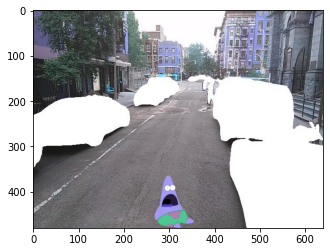

In [15]:
query1match = cv2.imread(database_path + matches_list[0])
plt.imshow(query1match)

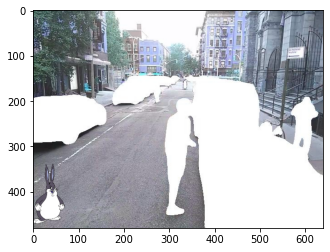

In [16]:
query2match = cv2.imread(database_path + matches_list[1])
plt.imshow(query2match)

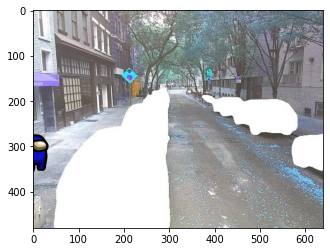

In [17]:
query3match = cv2.imread(database_path + matches_list[2])
plt.imshow(query3match)